In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

2025-06-26 11:33:22.925484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750937602.948088     117 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750937602.954824     117 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Configuration
DATA_DIR = "/kaggle/input/skin-cancer-disease-ham10000/Ham10000"
OUTPUT_DIR = "/kaggle/working/final_data"
PROCESSED_DIR = "/kaggle/working/processed_data"
TARGET_COUNT = 1100  # Number of images per class
RESIZE_DIM = (224, 224)  # Resize dimensions

# Ensure directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Initialize the Data Augmentation generator with improved parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',  # Changed from 'nearest'
    cval=0  # Fill with black (use 255 for white)
) 

# Function to load images in RGB format
def load_image_rgb(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB immediately

# Function to save images in RGB format
def save_image_rgb(path, img):
    # If image is grayscale, convert to 3-channel
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving

# Function to balance dataset (oversampling/undersampling) with Augmentation
def balance_dataset():
    for class_name in os.listdir(DATA_DIR):
        class_path = os.path.join(DATA_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
        
        images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        image_count = len(images)
        
        output_class_dir = os.path.join(OUTPUT_DIR, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        # If the number of images is greater than the target, randomly sample
        if image_count > TARGET_COUNT:
            images = random.sample(images, TARGET_COUNT)
        
        # If the number of images is less than the target, apply augmentation
        elif image_count < TARGET_COUNT:
            images_to_add = TARGET_COUNT - image_count
            images_copy = list(images)  # Create a copy of the list of images
            
            # Apply augmentation to existing images until we reach TARGET_COUNT
            for img_path in tqdm(images_copy, desc=f"Augmenting {class_name}"):
                img = load_image_rgb(img_path)
                img = cv2.resize(img, RESIZE_DIM)
                img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)

                # Generate augmented images and save them
                i = 0
                for batch in datagen.flow(img, batch_size=1, save_to_dir=output_class_dir, 
                                        save_prefix=class_name, save_format='jpg'):
                    i += 1
                    if i >= images_to_add // len(images_copy):  # Distribute augmentation evenly
                        break

        # Now copy original images to the output directory in RGB
        for idx, img_path in enumerate(tqdm(images, desc=f"Processing {class_name}")):
            img = load_image_rgb(img_path)
            img = cv2.resize(img, RESIZE_DIM)
            output_img_path = os.path.join(output_class_dir, f"{class_name}_{idx+1}.jpg")
            save_image_rgb(output_img_path, img)
    
    print("Dataset balanced and augmented successfully!")

In [3]:
# Function to check for black borders
def has_black_borders(img, threshold=10):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > threshold
    return not np.all(mask)

# Function to remove black borders
def zoom_until_no_borders(img, zoom_step=10, min_size=50):
    while has_black_borders(img):
        h, w, _ = img.shape
        if h <= min_size or w <= min_size:
            break
        img = img[zoom_step:h - zoom_step, zoom_step:w - zoom_step]
    return img

# Function to apply thresholding
def apply_threshold(gray_image, lower_gray=20, upper_gray=100):
    return cv2.inRange(gray_image, lower_gray, upper_gray)

# Function to find and draw contours
def find_and_draw_contours(image, mask, min_contour_area=500):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    for contour in contours:
        if cv2.contourArea(contour) >= min_contour_area:
            cv2.drawContours(image_with_contours, [contour], -1, (0, 255, 0), 2)
    return image_with_contours

# Function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if has_black_borders(image):
        image = zoom_until_no_borders(image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    equalized = cv2.equalizeHist(blurred)
    resized_color = cv2.resize(image, RESIZE_DIM)
    resized_gray = cv2.resize(equalized, RESIZE_DIM)
    
    mask = apply_threshold(resized_gray)
    gray_highlighted = cv2.bitwise_and(resized_gray, resized_gray, mask=mask)
    color_with_contours = find_and_draw_contours(resized_color, mask)
    gray_with_contours = find_and_draw_contours(resized_gray, mask)
    
    return {
        "original": resized_color,
        "gray": resized_gray,
        "highlighted": gray_highlighted,
        "color_contour": color_with_contours,
        "gray_contour": gray_with_contours
    }

# Function to create processed dataset
def create_processed_dataset():
    for class_name in os.listdir(OUTPUT_DIR):
        class_path = os.path.join(OUTPUT_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
        
        images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        images = random.sample(images, min(len(images), TARGET_COUNT))
        
        for img_path in tqdm(images, desc=f"Processing {class_name}"):
            processed_images = preprocess_image(img_path)
            for key, img in processed_images.items():
                output_class_dir = os.path.join(PROCESSED_DIR, key, class_name)
                os.makedirs(output_class_dir, exist_ok=True)
                output_img_path = os.path.join(output_class_dir, os.path.basename(img_path))
                cv2.imwrite(output_img_path, img)
    print("Processed dataset created successfully!")

# Function to count images in classes
def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
            print(f"Class '{class_name}': {num_images} images")
    return class_counts

# Run processes
balance_dataset()
create_processed_dataset()

# Example usage for counting images in a processed dataset
dataset_path = os.path.join(PROCESSED_DIR, "color_contour")
class_counts = count_images_in_classes(dataset_path)

Processing Dermatofibroma: 100%|██████████| 115/115 [00:00<00:00, 125.13it/s]


Dataset balanced and augmented successfully!


Processing Actinic keratoses: 100%|██████████| 960/960 [00:04<00:00, 231.57it/s]


Processed dataset created successfully!
Class 'Basal cell carcinoma': 1014 images
Class 'Melanoma': 1100 images
Class 'Vascular lesions': 956 images
Class 'Benign keratosis-like lesions': 1100 images
Class 'Dermatofibroma': 1001 images
Class 'Melanocytic nevi': 1100 images
Class 'Actinic keratoses': 960 images


In [17]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

# PARAMETERS
# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 50
EXCLUDED_CLASS = {"Benign keratosis-like lesions", "Basal cell carcinoma"}
DATA_DIR = '/kaggle/working/processed_data/color_contour'

# STEP 1: Build a DataFrame from the directory structure
data = []
for class_name in os.listdir(DATA_DIR):
    if class_name in EXCLUDED_CLASS:
        continue
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({
                  'filename': os.path.join(class_path, fname),
                    'class': class_name
                })


df = pd.DataFrame(data)

# STEP 2: Filter out the excluded class
df = df[df['class'] != EXCLUDED_CLASS]

# STEP 3: Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)

# STEP 4: Create image data generators
datagen = ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # brightness_range=[0.8, 1.2]
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    # target_size=IMAGE_SIZE,
    # batch_size=BATCH_SIZE,
    # class_mode='categorical',
    # target_size=(224, 224),
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    # target_size=IMAGE_SIZE,
    # batch_size=BATCH_SIZE,
    # class_mode='categorical',
    # shuffle=False
    # target_size=(224, 224),
    target_size=IMAGE_SIZE, 
    batch_size=32,
    class_mode='categorical'
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"Number of classes after removal: {NUM_CLASSES}")


Found 3581 validated image filenames belonging to 5 classes.
Found 1536 validated image filenames belonging to 5 classes.
Number of classes after removal: 5


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Freeze first 80 layers
for layer in base_model.layers[:80]:
    layer.trainable = False

# Build model
x = base_model.output

# Conv Block 1
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

# Conv Block 2
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

# Conv Block 3
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# Optional dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Final output
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_MobileNetV2 = Model(inputs=base_model.input, outputs=predictions)

# Compile
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model_MobileNetV2.compile(optimizer=Adam(1e-4),
                          loss=loss_fn,
                          metrics=['accuracy'])

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train
model_MobileNetV2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 602ms/step - accuracy: 0.2132 - loss: 2.1707 - val_accuracy: 0.2500 - val_loss: 1.6038 - learning_rate: 1.0000e-04
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.2724 - loss: 1.8242 - val_accuracy: 0.3112 - val_loss: 1.5583 - learning_rate: 1.0000e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - accuracy: 0.3399 - loss: 1.6316 - val_accuracy: 0.4180 - val_loss: 1.4391 - learning_rate: 1.0000e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - accuracy: 0.4753 - loss: 1.4107 - val_accuracy: 0.5137 - val_loss: 1.3099 - learning_rate: 1.0000e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - accuracy: 0.5283 - loss: 1.2965 - val_accuracy: 0.5319 - val_loss: 1.2665 - learning_rate: 1.0000e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - accuracy: 0.5992 - loss: 1.1955 - val_accuracy: 0.5938 - val_loss: 1.1800 - learning_rate: 1.0000e-04
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 52s 4

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

EPOCHS = 50


# =====================
# CLASS WEIGHTS
# =====================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# =====================
# MODEL BUILDING
# =====================
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
base_model.trainable = True

# Optionally freeze first N layers
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# =====================
# COMPILE MODEL
# =====================
lr_schedule = CosineDecay(initial_learning_rate=1e-3, decay_steps=10000, alpha=1e-5)
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# =====================
# CALLBACKS
# =====================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# =====================
# TRAIN MODEL
# =====================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/50


E0000 00:00:1750942672.285830     170 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942672.482795     170 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942673.126475     170 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942673.346342     170 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942673.793865     170 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 14/112 ━━━━━━━━━━━━━━━━━━━━ 1:00 615ms/step - accuracy: 0.2007 - loss: 2.5626

E0000 00:00:1750942727.337302     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942727.538055     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942728.178192     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942728.399391     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750942728.830604     172 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

112/112 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.2552 - loss: 2.1859 - val_accuracy: 0.2148 - val_loss: 1.6397 - learning_rate: 9.9969e-04
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 105s 937ms/step - accuracy: 0.3408 - loss: 1.6787 - val_accuracy: 0.2350 - val_loss: 1.5987 - learning_rate: 9.9876e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 104s 928ms/step - accuracy: 0.4069 - loss: 1.5617 - val_accuracy: 0.3822 - val_loss: 17.0253 - learning_rate: 9.9722e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 102s 912ms/step - accuracy: 0.4836 - loss: 1.4316 - val_accuracy: 0.4355 - val_loss: 1.5725 - learning_rate: 9.9506e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 104s 930ms/step - accuracy: 0.4853 - loss: 1.4044 - val_accuracy: 0.4557 - val_loss: 25.9848 - learning_rate: 9.9228e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 105s 939ms/step - accuracy: 0.5581 - loss: 1.2491 - val_accuracy: 0.2174 - val_loss: 3.0829 - learning_rate: 9.8890e-04
Epoch 7/50
 35/112 ━━━━━━━━━━━━━━━━━━━━ 52s 677ms/st

48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step


<Figure size 1000x800 with 0 Axes>

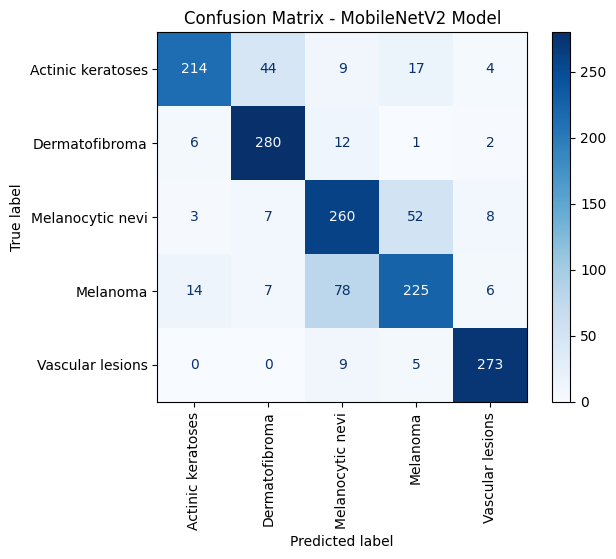

Accuracy: 0.8151


In [7]:
# # Get true labels
# y_true = val_generator.classes

# # Get predicted labels
# y_pred_probs = model_MobileNetV2.predict(val_generator)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Class labels
# class_labels = list(val_generator.class_indices.keys())

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Display the confusion matrix
# plt.figure(figsize=(10, 8))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
# plt.title("Confusion Matrix - MobileNetV2 Model")
# plt.show()

# from sklearn.metrics import accuracy_score

# # Calculate accuracy
# accuracy = accuracy_score(y_true, y_pred)
# print(f"Accuracy: {accuracy:.4f}")


In [8]:
# # Build the model
# model_try = Sequential([
#     # Block 1
#     Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
#     BatchNormalization(),
#     Conv2D(32, (3,3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     # Block 2
#     Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     # Block 3
#     Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     # Block 4
#     Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     # Block 5
#     Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     Conv2D(512, (1,1), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),  # Depth increase without changing dimensions
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     # Block 6
#     Conv2D(1024, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     Conv2D(1024, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),
#     BatchNormalization(),
#     Conv2D(1024, (1,1), activation='relu', padding='same', kernel_regularizer=l2(1e-5)),  # Depth increase without changing dimensions
#     BatchNormalization(),
#     MaxPooling2D(2, 2),
    

#     # Classification head
#     GlobalAveragePooling2D(),  # Replaces Flatten, reduces overfitting
#     Dropout(0.5),
#     Dense(1024, activation='relu', kernel_regularizer=l2(1e-5)),
#     Dropout(0.5),
#     Dense(NUM_CLASSES, activation='softmax')
# ])

# # Compile the model
# model_try.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Callbacks
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
#     #ModelCheckpoint('best_model.h5', save_best_only=True)
# ]


# class_weights = compute_class_weight('balanced',
#                                      classes=np.unique(train_generator.classes),
#                                      y=train_generator.classes)

# class_weight_dict = dict(enumerate(class_weights))

# # Train
# model_try.fit(
#     train_generator,
#     class_weight=class_weight_dict,
#     validation_data=val_generator,
#     epochs=EPOCHS,
#     callbacks=callbacks
# )

In [9]:
# # Get true labels
# y_true = val_generator.classes

# # Get predicted labels
# y_pred_probs = model_try.predict(val_generator)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Class labels
# class_labels = list(val_generator.class_indices.keys())

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Display the confusion matrix
# plt.figure(figsize=(10, 8))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
# plt.title("Confusion Matrix - Try Model")
# plt.show()

# from sklearn.metrics import accuracy_score

# accuracy = accuracy_score(y_true, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

In [10]:
# # Load base model
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the base model
# base_model.trainable = True

# # Optionally, freeze only the first N layers
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# # Start building model
# x = base_model.output  # <- This is a 4D tensor

# x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Dropout(0.3)(x)
# x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Dropout(0.3)(x)
# x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# model_MobileNetV2 = Model(inputs=base_model.input, outputs=predictions)

# # Compile
# model_MobileNetV2.compile(optimizer=Adam(1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


# class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
# class_weights = dict(enumerate(class_weights))

# from tensorflow.keras.callbacks import LearningRateScheduler
# import tensorflow as tf

# def scheduler(epoch, lr):
#     if epoch < 5:
#         return lr
#     else:
#         return float(lr * tf.math.exp(-0.1).numpy())

# lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
#     lr_scheduler
# ]


# # Train
# model_MobileNetV2.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     class_weight=class_weights
# )

In [11]:
# import numpy as np
# import math
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, LearningRateScheduler
# from sklearn.utils.class_weight import compute_class_weight

# # Constants (define these before running)
# # NUM_CLASSES = number of classes in your dataset
# # EPOCHS = total training epochs
# # train_generator and val_generator should be defined using ImageDataGenerator or similar

# # Load base model
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze first 100 layers
# base_model.trainable = True
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# # Build the model
# x = base_model.output
# x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Dropout(0.3)(x)
# x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D()(x)
# x = Dropout(0.3)(x)
# x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
# x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# model_MobileNetV2 = Model(inputs=base_model.input, outputs=predictions)

# # Compile
# model_MobileNetV2.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Compute class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_generator.classes),
#     y=train_generator.classes
# )
# class_weights = dict(enumerate(class_weights))


# # Learning rate tracker
# lr_tracker = LambdaCallback(
#     on_epoch_end=lambda epoch, logs: print(
#         f"Epoch {epoch + 1}: learning rate is {model_MobileNetV2.optimizer.learning_rate.numpy():.8f}")
# )

# # Callbacks list
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
#     lr_tracker
# ]

# # Train the model
# model_MobileNetV2.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=EPOCHS,
#     class_weight=class_weights,
#     callbacks=callbacks
# )
